Importing Needed Libraries

In [6]:
#Step 1: Import Libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


Loading and Preprocessing Dataset

In [7]:
#Step 2: Load and Prepare the Dataset
df = pd.read_csv("mice_protein_expression.csv")
df = df.dropna()  # Drop rows with missing protein values
df = df.drop(columns=["MouseID", "Genotype", "Treatment", "Behavior"])  # Drop metadata

# Split features and labels
X_raw = df.drop(columns=["class"]).values
y_raw = df["class"].values

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)

# Create scaled and unscaled versions
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

Defining Support Vector Machine(SVM) Evalution Function

In [8]:
#Step 3: Define Evaluation Function
def evaluate_svm(X, y, C_values, sample_ratios, scaled_label):
    results = []

    for sample_ratio in sample_ratios:
        if sample_ratio < 1.0:
            X_part, _, y_part, _ = train_test_split(X, y, train_size=sample_ratio, stratify=y, random_state=42)
        else:
            X_part, y_part = X, y

        X_train, X_test, y_train, y_test = train_test_split(X_part, y_part, test_size=0.2, stratify=y_part, random_state=42)

        for C in C_values:
            model = LinearSVC(C=C, max_iter=50000)
            start_time = time.time()
            model.fit(X_train, y_train)
            train_time = time.time() - start_time

            y_pred = model.predict(X_test)
            acc_holdout = accuracy_score(y_test, y_pred)
            f1_holdout = cross_val_score(model, X_train, y_train, cv=5, scoring="f1_weighted").mean()
            f1_cv_full = cross_val_score(model, X_part, y_part, cv=5, scoring="f1_weighted").mean()

            results.append({
                "Sample Ratio": sample_ratio,
                "C": C,
                "Scaled": scaled_label,
                "Accuracy (Holdout)": acc_holdout,
                "F1 (Holdout CV)": f1_holdout,
                "F1 (Full CV)": f1_cv_full,
                "Training Time (s)": train_time
            })

    return pd.DataFrame(results)


Runing Evaluation

In [9]:
#Step 4: Run SVM Evaluations
C_values = [0.1, 1.0, 10.0]
sample_ratios = [1.0, 0.5, 0.25]

#Scaled results
scaled_results_df = evaluate_svm(X_scaled, y_encoded, C_values, sample_ratios, scaled_label=True)

#Unscaled results
unscaled_results_df = evaluate_svm(X_raw, y_encoded, C_values, sample_ratios, scaled_label=False)

#Merge results
final_results_df = pd.concat([scaled_results_df, unscaled_results_df], ignore_index=True)

Plotting Results

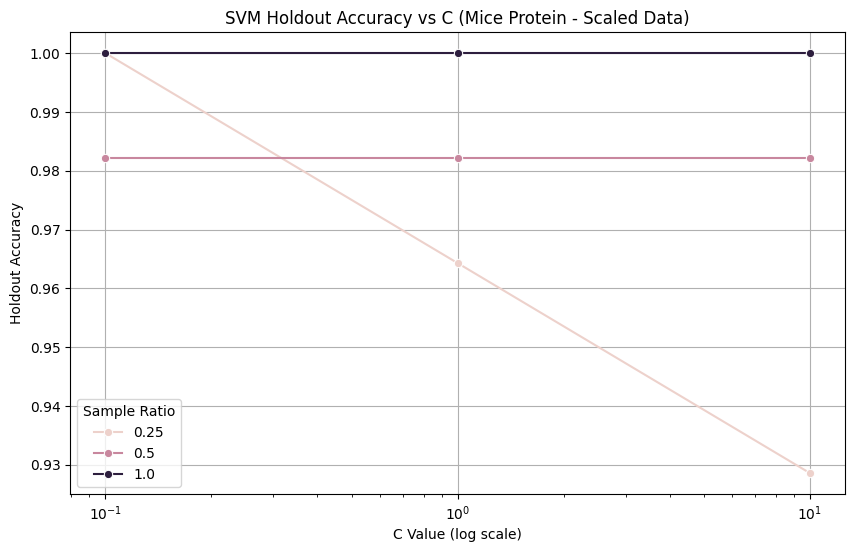

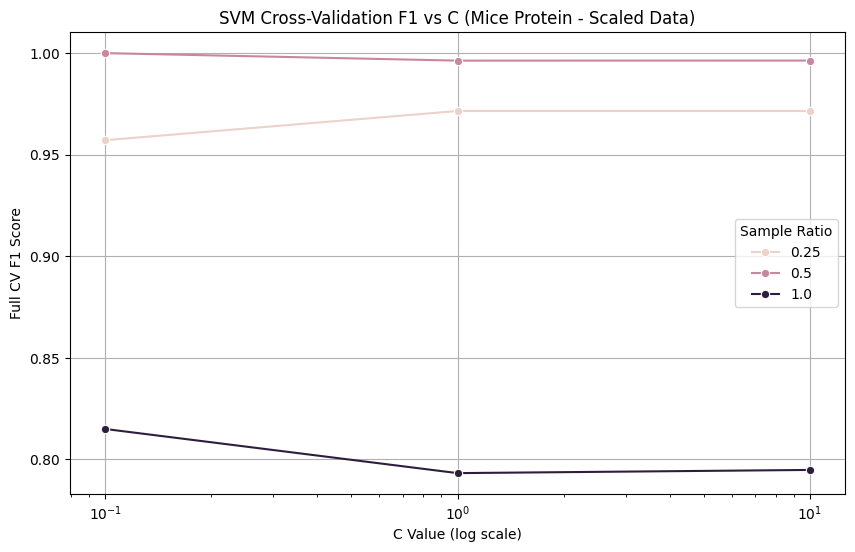

SVM Evaluation Complete for Mice Protein Dataset
    Sample Ratio     C  Scaled  Accuracy (Holdout)  F1 (Holdout CV)  \
0           1.00   0.1    True            1.000000         0.993071   
1           1.00   1.0    True            1.000000         0.997731   
2           1.00  10.0    True            1.000000         0.997731   
3           0.50   0.1    True            0.982143         1.000000   
4           0.50   1.0    True            0.982143         0.995423   
5           0.50  10.0    True            0.982143         0.995423   
6           0.25   0.1    True            1.000000         0.919329   
7           0.25   1.0    True            0.964286         0.918319   
8           0.25  10.0    True            0.928571         0.918319   
9           1.00   0.1   False            0.900901         0.872687   
10          1.00   1.0   False            0.990991         0.986233   
11          1.00  10.0   False            1.000000         0.995454   
12          0.50   0.1   Fal

In [10]:

#Step 5: Plot Results
plt.figure(figsize=(10, 6))
sns.lineplot(data=final_results_df[final_results_df["Scaled"] == True], x="C", y="Accuracy (Holdout)", hue="Sample Ratio", marker="o")
plt.xscale('log')
plt.title("SVM Holdout Accuracy vs C (Mice Protein - Scaled Data)")
plt.xlabel("C Value (log scale)")
plt.ylabel("Holdout Accuracy")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=final_results_df[final_results_df["Scaled"] == True], x="C", y="F1 (Full CV)", hue="Sample Ratio", marker="o")
plt.xscale('log')
plt.title("SVM Cross-Validation F1 vs C (Mice Protein - Scaled Data)")
plt.xlabel("C Value (log scale)")
plt.ylabel("Full CV F1 Score")
plt.grid(True)
plt.show()

#Final output
print("SVM Evaluation Complete for Mice Protein Dataset")
print(final_results_df)
